## Jason's toy model in Q-learning 
Thanks for this useful link:https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial <br>
So far, Reinforcement learning algorithms are not well GPU optimized since it's hard to do parallization in updating stages + reward. Thus, the DQN part is CPU only :) <br>
Thanks to this useful link : https://adventuresinmachinelearning.com/reinforcement-learning-tensorflow/ <br>
Here we didn't consider the Volume


# What's new:
Add tick dataset :) <br>
Add transaction fee <br>
The model needs to learn how to avoid the cost from transaction fee, which means it should avoid buying too many times <br>
You can add a supplimentary model for Qnet (No consideration for transaction fee), and let it consider the transaction cost <br>
A trail model will be: Use a LSTM and input action and output the same way with loss = loss-transaction fee <br>
The model simply decide whether to execute this order or just stay. Buy and sell are determined by Qnet <br>

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import tensorflow as tf
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
color_array = list(mcolors.CSS4_COLORS.keys())
root_path = 'Data/Stocks/'
#root_path = "/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/"

## Here we got 2 sets of data: Google stock price daily and Google stock price in 5 days (sample rate=1min)

df = pd.read_csv(root_path + "googl.us.txt")
# This time Let's do apple :)
df_hf = pd.read_csv("Data/High_frequency_data/GOOG_stock_1minute_sample/GOOG_sample.txt",names=["DateTime", "Open", "High", "Low", "Close","Volume"])



In [9]:
# For tick data
#df_hf = pd.read_csv("Data/High_frequency_data/GOOG_stock_tick_sample/GOOG_2020-07-01.txt",names=["DateTime", "Close","Volume"],index_col=3)
#df_hf.set_index(np.arange(0,df_hf.shape[0],1),inplace=True)


In [10]:
df_hf.head()

,DateTime,Open,High,Low,Close,Volume
0,2020-01-02 04:00:00,1342.00,1342.20,1342.00,1342.20,424
1,2020-01-02 04:02:00,1344.20,1344.20,1344.20,1344.20,177
2,2020-01-02 08:00:00,1337.02,1337.02,1337.02,1337.02,329
3,2020-01-02 08:09:00,1347.00,1347.00,1347.00,1347.00,155
4,2020-01-02 08:55:00,1348.00,1348.00,1348.00,1348.00,190


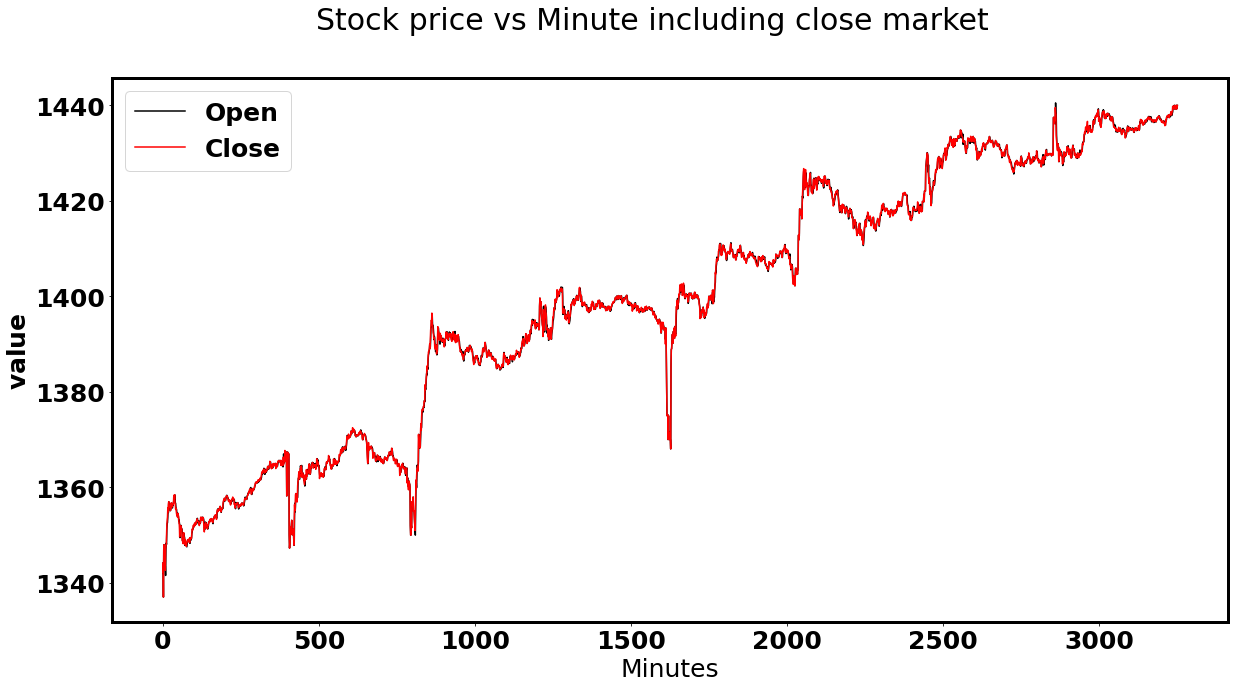

In [11]:
import matplotlib
from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

plt.plot(df_hf["Open"],"k",label= "Open")
plt.plot(df_hf["Close"],"r",label= "Close")

plt.xlabel("Minutes")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Stock price vs Minute including close market")
plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20,10)

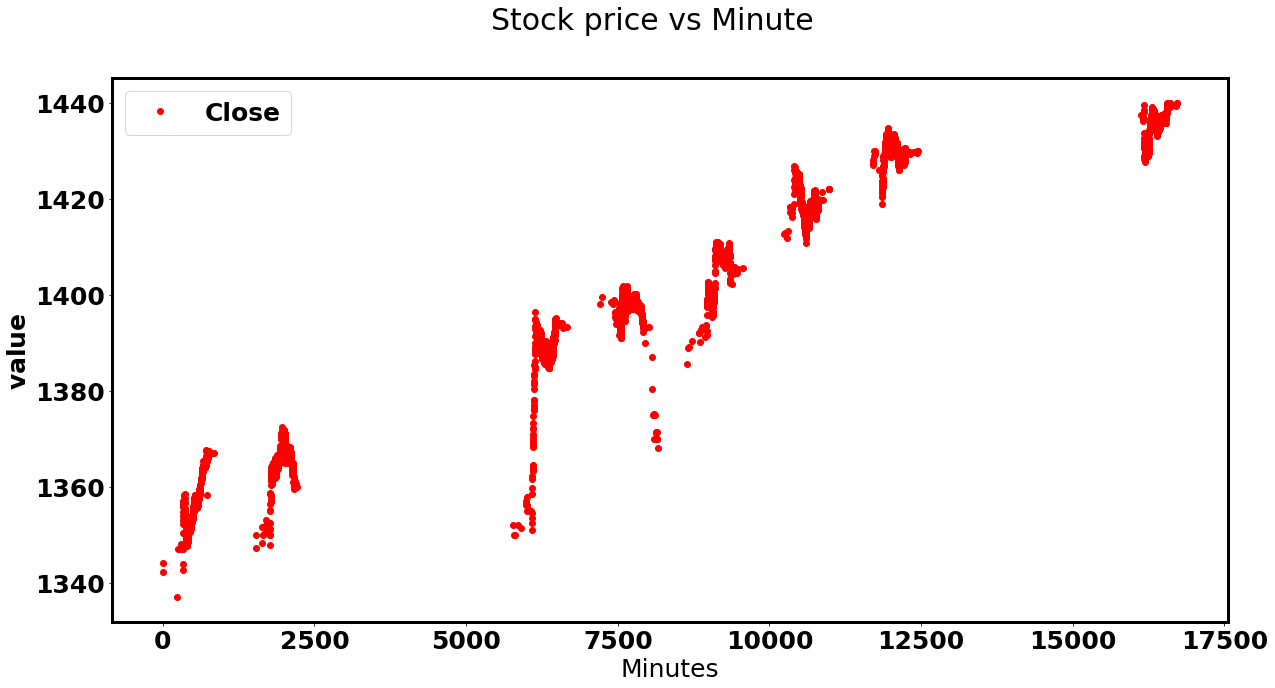

In [12]:

#df_hf["DateTime"] = pd.to_datetime(df_hf["DateTime"], format="%Y-%m-%d %H:%M:%S:%f")
df_hf["DateTime"] = pd.to_datetime(df_hf["DateTime"])
delta_min = (df_hf["DateTime"]-df_hf["DateTime"][0]).dt.total_seconds()//60

import matplotlib
from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

#plt.plot(delta_min,df_hf["Open"],"kx",label= "Open")
plt.plot(delta_min,df_hf["Close"],"ro",label= "Close")

plt.xlabel("Minutes")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Stock price vs Minute")
plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20,10)

In [45]:
# This time Try DQN on df and df_hf
# History_t set to be 90, you can change that

class Environment1:
    # def __init__(self, data, history_t=90):
    def __init__(self, data, history_t=100):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    # Here we add transaction fee:
                    #profits += (self.data.iloc[self.t, :]['Close'] - p)
                    # For google 
                    ratio = 0.005
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                profits -=self.data.iloc[self.t, :]['Close']*ratio
                reward += profits
                
                
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done


In [46]:
"""

# df

df['Date'] = pd.to_datetime(df['Date'])
data = df.set_index('Date')
env = Environment1(df)



"""

# df_hf



data_hf = df_hf.set_index('DateTime')
env_hf = Environment1(df_hf)


In [47]:
delta_split = int(df_hf.shape[0]*0.7)
train_hf = df_hf[:delta_split]
test_hf = df_hf[delta_split:]
print("Training date length hf",len(train_hf),"testing date length hf", len(test_hf))

Training date length hf 2275 testing date length hf 976


In [48]:
import chainer
import chainer.functions as F
import chainer.links as L
import copy
import time

# Most of the codes are not about NN. Using TF doesn't help much.
import tensorflow as tf

from chainer.backends import cuda




def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
            
    # GPU?
    # Q_Network.to_gpu()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    

    
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)
    
    # Hyper-parameters
    epoch_num = 200
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5


    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards



In [49]:
# Dueling Double DQN

def train_dddqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    """ >>> """

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [50]:
# Train on google_per_minute:

#Q, total_losses, total_rewards = train_dddqn(Environment1(train_hf))

# Epoch, epsilon (Randomness in your strategy), steps,log[reward],log[loss], elapsed time
Q, total_losses, total_rewards = train_dqn(Environment1(train_hf))

5	0.0999999999999992	11370	-243.2	12853.826605420258	153.24296116828918
10	0.0999999999999992	22740	-297.4	8275.739379123692	103.91274070739746
15	0.0999999999999992	34110	-113.8	627.7842211717041	118.36311626434326
20	0.0999999999999992	45480	-107.4	670.037490298337	109.09995150566101
25	0.0999999999999992	56850	-77.4	341.0191555555328	114.22137832641602
30	0.0999999999999992	68220	-73.4	379.66731108367384	117.39947152137756
35	0.0999999999999992	79590	-62.8	126.42793183005415	117.11493301391602
40	0.0999999999999992	90960	-65.8	93.56241369425553	114.88094806671143
45	0.0999999999999992	102330	-62.6	643.0793098384078	123.49127268791199
50	0.0999999999999992	113700	-88.0	93.33968916129088	121.82072806358337
55	0.0999999999999992	125070	-52.8	18.066829664897522	114.98169302940369
60	0.0999999999999992	136440	-41.0	12.02396056271682	174.13280534744263
65	0.0999999999999992	147810	-41.6	10.276505476390593	181.06138348579407
70	0.0999999999999992	159180	-24.4	20.650291239497893	196.5378248

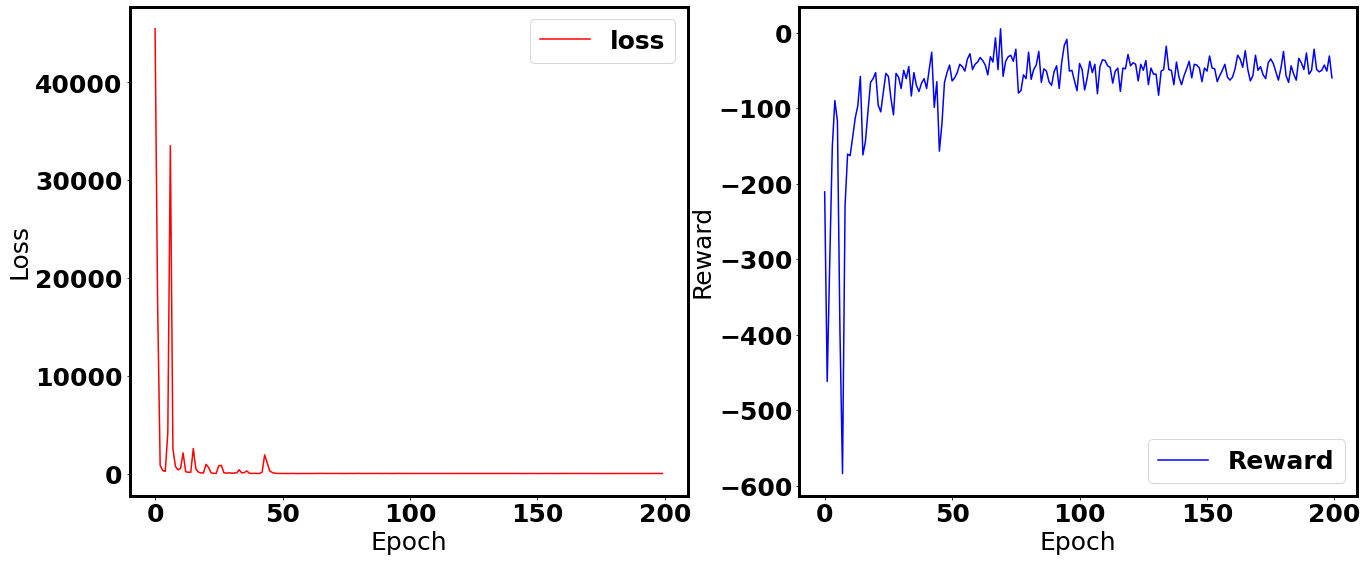

In [51]:

plt.subplot(1,2,1)
plt.plot(total_losses,"r",label="loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(total_rewards,"b",label="Reward")
plt.xlabel("Epoch")
plt.ylabel("Reward")

plt.legend()



fig = matplotlib.pyplot.gcf()

fig.set_size_inches(22,9)
plt.legend()
plt.show()

In [52]:
# Testing :)

# test
test_env = Environment1(test_hf)


# test
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data) - 1):
    pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
    pact = np.argmax(pact.data)
    test_acts.append(pact)

    obs, reward, done = test_env.step(pact)
    test_rewards.append(reward)

    pobs = obs

test_profits = test_env.profits


print("Test profit =%.4f in %d steps start price %.4f"%(test_profits,test_env.data.shape[0],test_env.data.iloc[0,1]))

Test profit =143.9194 in 976 steps start price 1416.0400


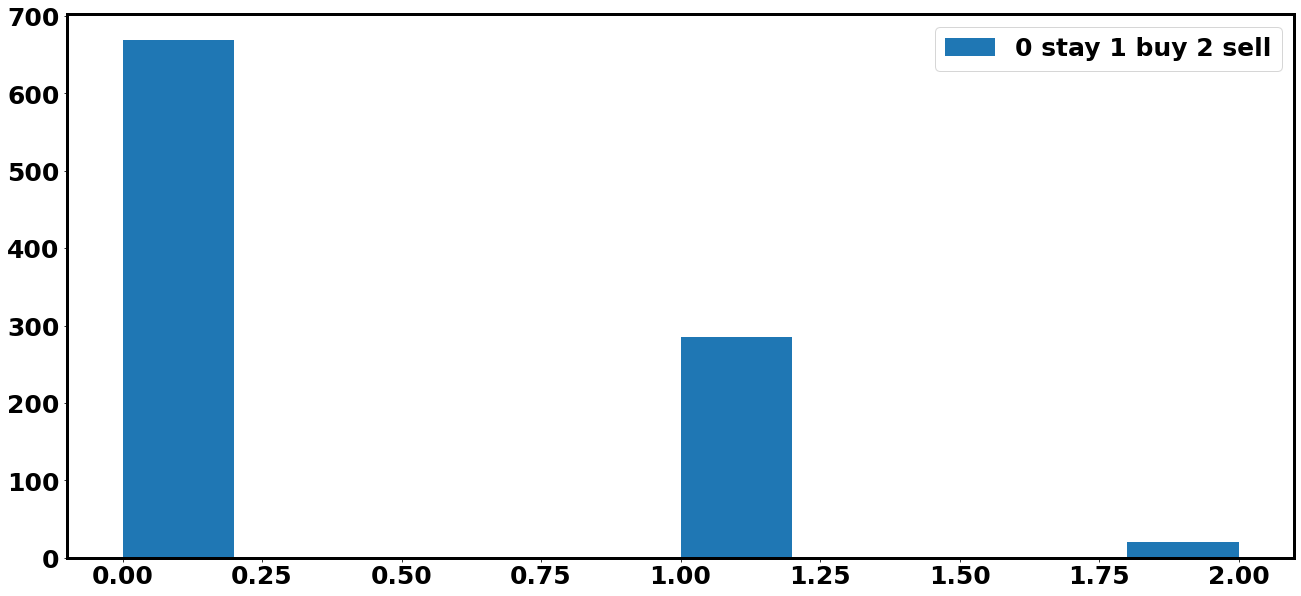

In [53]:
# Our actions in testing set:
# Here 0 means stay, 1 means buy 2 means sell
plt.hist(test_acts,label = "0 stay 1 buy 2 sell")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(22,10)
plt.legend()
plt.show()


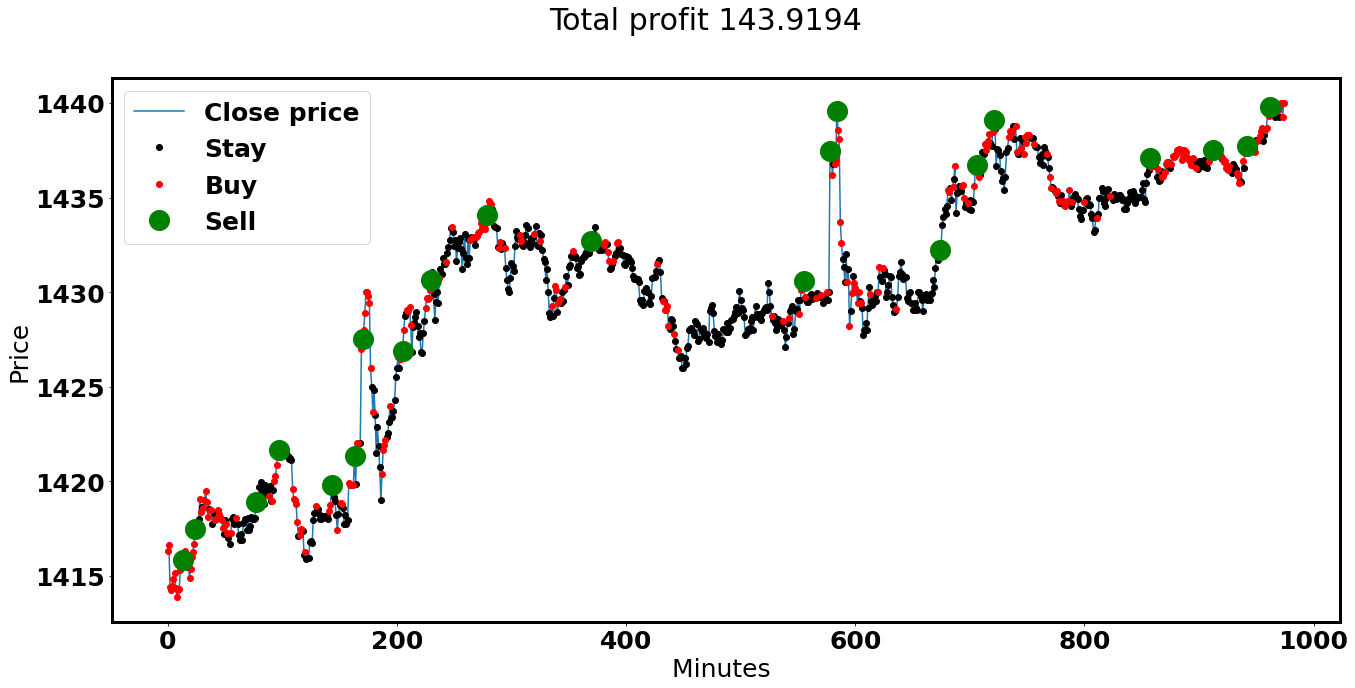

In [89]:
delta_sec = (test_env.data["DateTime"]-test_env.data.iloc[0,0]).dt.total_seconds()

plt.subplot(1,1,1)
y = test_env.data["Close"].values[:-1]

test_acts = np.array(test_acts)

m0 = test_acts==0
m1 = test_acts==1
m2 = test_acts==2
plt.plot(np.arange(0,len(y),1),y,label = "Close price")
plt.plot(np.arange(0,len(y),1)[m0],y[m0],"ko",label = "Stay")
plt.plot(np.arange(0,len(y),1)[m1],y[m1],"ro",label = "Buy")
plt.plot(np.arange(0,len(y),1)[m2],y[m2],"go",label = "Sell",markersize=20)

plt.xlabel("Minutes ")
plt.ylabel("Price")
plt.suptitle("Total profit %.4f"%test_profits)



fig = matplotlib.pyplot.gcf()

fig.set_size_inches(22,10)
plt.legend()
plt.show()

In [55]:
print("All Set")

All Set


In [90]:
# No limit on max history size

def profit_calculator(data,actions):
    ans = 0
    # For Google it's 0.5% transaction fee
    ratio = 0.005
    history = []
    
    for i in range(len(data)):
        if actions[i]==0:
            pass
        elif actions[i]==1:
            history.append(data[i])
        else:
            ans += len(history)*data[i]-np.sum(history)-len(history)*0.05
            print("size of history",len(history))
            history = []
    return ans
            
        
# print(profit_calculator(data=y,actions=test_acts))
        

In [91]:
def profit_calculator_mod(data,actions):
    ans = 0
    # For Google it's 0.5% transaction fee
    ratio = 0.005
    history = []
    
    for i in range(len(data)):
        if actions[i]==0:
            pass
        elif actions[i]==1 and actions[max(0,i-1)]==1 and actions[min(len(data)-1,i+1)]==2:
            history.append(data[i])
        else:
            ans += len(history)*data[i]-np.sum(history)-len(history)*0.05
            history = []
    return ans
            
        
# print(profit_calculator_mod(data=y,actions=test_acts))
        

# Idea 2: Naive one :)
Since there is a lot of buy, we need to reduce them. Sell them with caution only if the profit is positive after deducting the transaction fee.





In [96]:
import copy
window_size = 50
threthold = 50
threthold_p = 1
max_history_length = 10

def helper(data,actions):
    ans = 0
    max_history = 0
    mean_d = np.nanmean(data)
    actions_modified = copy.copy(actions)
    
    # For Google it's 0.5% transaction fee
    ratio = 0.005
    history = []
    
    for i in range(len(data)):
        if actions[i]==0:
            pass
        elif actions[i]==1:
            temp = actions[max(0,i-window_size//2):i]
            temp = list(temp)
            #print(temp)
            if temp.count(1)>threthold/100*len(temp) and len(history)<max_history_length:
                # buy
                history.append(data[i])
            else:
                # stay
                actions_modified[i]=0
                
        else:
            # p = len(history)*data[i]-np.sum(history)*(1+ratio)
            p = len(history)*data[i]-np.sum(history)-len(history)*0.05
            #print(p)
            if p>mean_d*threthold_p/100:
                # sell:
                ans += p 
                history = []
            else:
                # stay
                actions_modified[i]=0
            
    return ans,actions_modified

profit,test_acts_mod = helper(data=test_env.data["Close"].values[:-1],actions=test_acts)
print(profit)

174.2062000000049


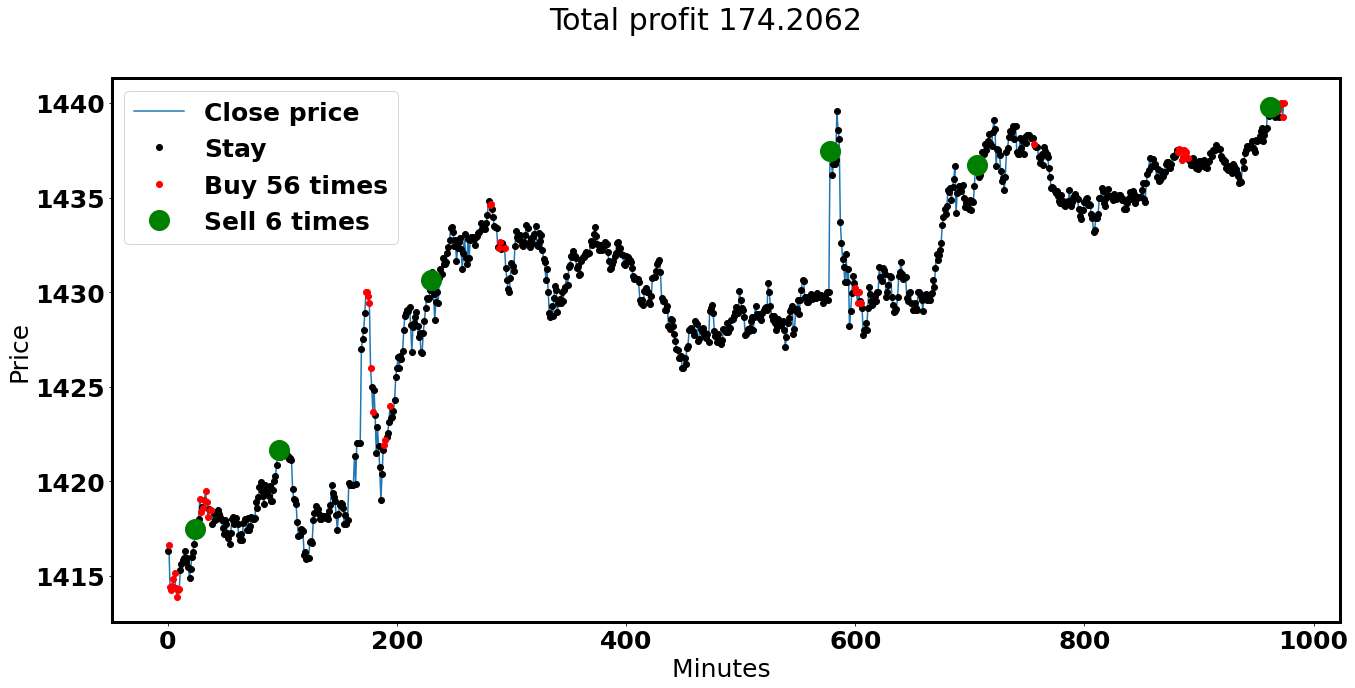

In [97]:
delta_sec = (test_env.data["DateTime"]-test_env.data.iloc[0,0]).dt.total_seconds()

plt.subplot(1,1,1)
y = test_env.data["Close"].values[:-1]


m0 = test_acts_mod==0
m1 = test_acts_mod==1
m2 = test_acts_mod==2
plt.plot(np.arange(0,len(y),1),y,label = "Close price")
plt.plot(np.arange(0,len(y),1)[m0],y[m0],"ko",label = "Stay")
plt.plot(np.arange(0,len(y),1)[m1],y[m1],"ro",label = "Buy %d times"%len(y[m1]))
plt.plot(np.arange(0,len(y),1)[m2],y[m2],"go",label = "Sell %d times"%len(y[m2]),markersize=20)

plt.xlabel("Minutes ")
plt.ylabel("Price")
plt.suptitle("Total profit %.4f"%profit)



fig = matplotlib.pyplot.gcf()

fig.set_size_inches(22,10)
plt.legend()
plt.show()


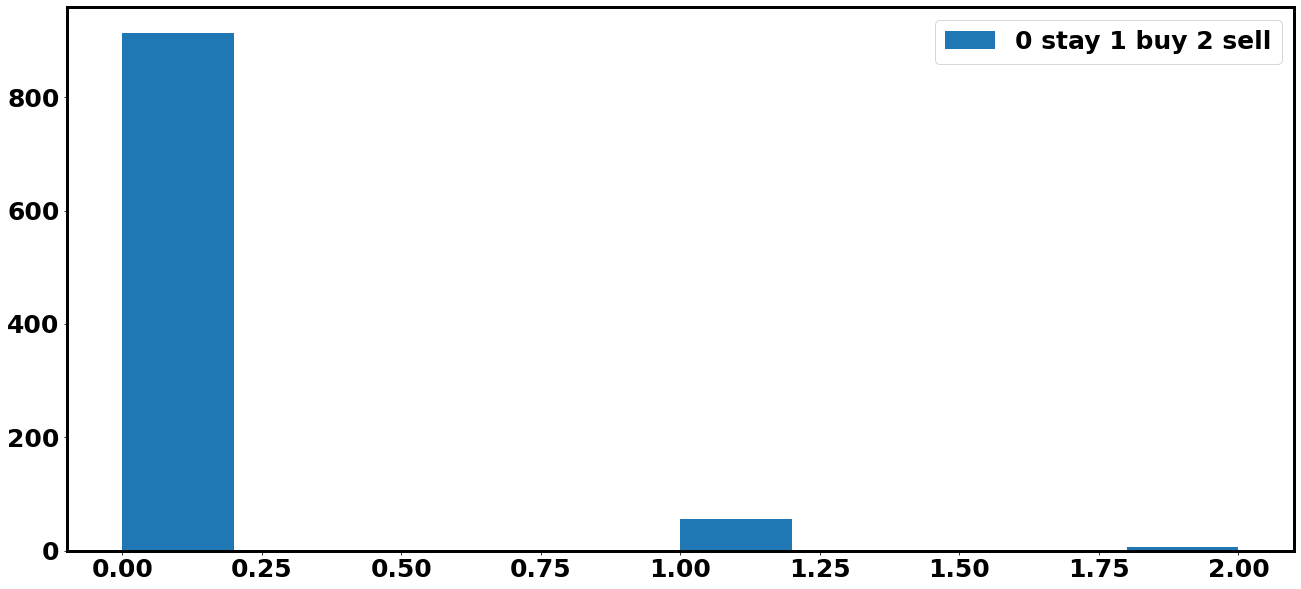

In [98]:
# Our actions in testing set:
# Here 0 means stay, 1 means buy 2 means sell
plt.hist(test_acts_mod,label = "0 stay 1 buy 2 sell")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(22,10)
plt.legend()
plt.show()

